In [89]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from pathlib import Path

In [253]:
def read_depth_exr_file(filepath: Path):
    exrfile = exr.InputFile(filepath.as_posix())
    raw_bytes = exrfile.channel('B', Imath.PixelType(Imath.PixelType.FLOAT))
    depth_vector = numpy.frombuffer(raw_bytes, dtype=numpy.float32)
    height = exrfile.header()['displayWindow'].max.y + 1 - exrfile.header()['displayWindow'].min.y
    width = exrfile.header()['displayWindow'].max.x + 1 - exrfile.header()['displayWindow'].min.x
    depth_map = numpy.reshape(depth_vector, (height, width))
    return depth_map

def read_exr(path, img_pass="depth"):
    if not os.path.exists(path):
        print("Path does not exist", path)
        return np.array([])
    
    flag = cv2.IMREAD_ANYDEPTH if img_pass == "depth" else cv2.IMREAD_ANYCOLOR
    data = cv2.imread(path, flag)
    
    if img_pass == "normals":
        data = cv2.imread(path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        
    data = np.array(data)
    return data

In [268]:
normals = read_exr("/om/user/yyf/CommonFate/scenes/test_noise/shapegen_3/scene_029/normals/Image0001.exr", img_pass="normals")
d = read_exr("/om/user/yyf/CommonFate/scenes/test_noise/shapegen_3/scene_024/depth/Image0001.exr", img_pass="depth")
# d = d / d.max()
print(d.shape)
# d = (d - d.min()) /(d.max() - d.min())

(512, 512)


In [269]:
def load_pose(filename):
    lines = open(filename).read().splitlines()
    if len(lines) == 1:
        pose = np.zeros((4, 4), dtype=np.float32)
        for i in range(16):
            pose[i // 4, i % 4] = lines[0].split(" ")[i]
        return pose.squeeze()
    else:
        lines = [[x[0], x[1], x[2], x[3]] for x in (x.split(" ") for x in lines[:4])]
        
    return np.asarray(lines).astype(np.float32).squeeze()

    
def world2cam_normals(np_array):
    extrinsics_fname =  str("/home/yyf/CommonFate") + "/camera_extrinsics.txt"
    extrinsics = load_pose(extrinsics_fname)

    rotation = np.linalg.inv(extrinsics[:3, :3])
    rotated = np.einsum('ij,abj->abi', rotation, np_array)
    
    return rotated

In [270]:
cam_normals = world2cam_normals(normals)
coloring = ((cam_normals * 0.5 + 0.5) * 255)

alpha_channel = np.ones_like(coloring[:, :, :1]) * 255
rgba = np.concatenate((coloring, alpha_channel), axis=-1)

rgba[np.logical_and(rgba[:, :, 0] == 127.5, rgba[:, :, 1] == 127.5, rgba[:, :, 2] == 127.5), :] = 0.
rgba = rgba.astype(np.uint8)

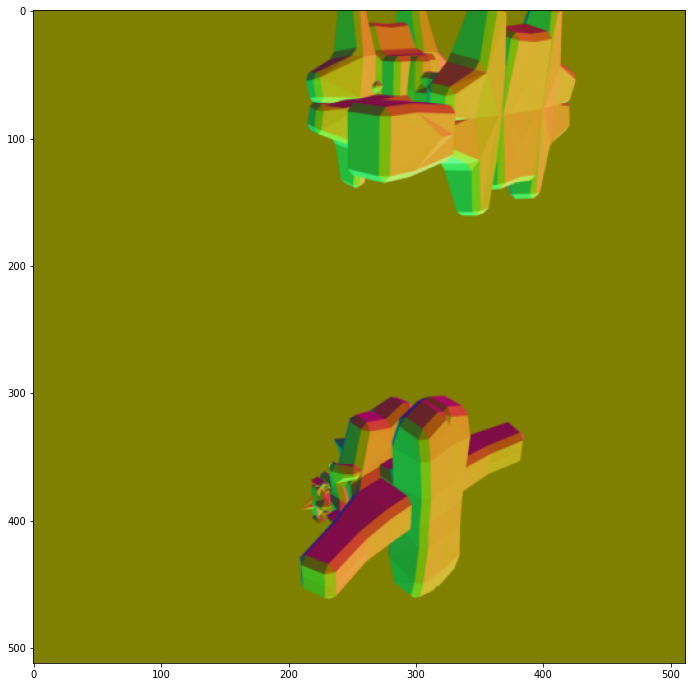

In [271]:
fig = plt.figure(figsize=(16,12))
plt.imshow(rgba)